In [45]:
%matplotlib inline
import numpy as np
import pandas as pd
import random
import torch
from torch.utils import data
from d2l import torch as d2l

In [12]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b  # 矩阵乘法
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [21]:
labels.shape

torch.Size([1000, 1])

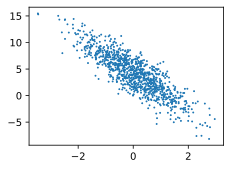

In [14]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

In [61]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) # 随机打乱indices中的排序
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
    

In [63]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)  # 初始化待训练的参数
b = torch.zeros(1, requires_grad=True)

def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return ((y_hat - y.reshape(y_hat.shape)) ** 2) # 为什么.sum()放到这里就会导致结果收敛不了呢？？？


def sgd(params, lr, batch_size):  #@save  # 注意：parmas是以一个list的格式输入的，所以需要for循环更新参数
    """小批量随机梯度下降"""
    with torch.no_grad(): # 表明当前的计算不需要反向传播， 因为params的梯度已经在初始化的时候记录过了
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()  #保证下一次调用的时候不会受到上一次参数梯度的影响



In [64]:
lr = 0.03
num_epochs = 5
net = linreg
loss = squared_loss
batch_size = 10

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()  # .sum()要放到这里
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.390475
epoch 2, loss 0.103578
epoch 3, loss 0.103298
epoch 4, loss 0.103820
epoch 5, loss 0.103058


In [43]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-6.0678e-04,  9.0361e-05], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0003], grad_fn=<RsubBackward1>)


线性回归的简洁实现

In [46]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [50]:
# nn是神经网络的缩写
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()  # 模型参数更新
    with torch.no_grad():   # 这个是我加上去的，课的QA说下面的代码不会影响grad的记录，我感觉还是得学习一下pytorch的计算图逻辑
        l = loss(net(features), labels)
        print(f'epoch {epoch + 1}, loss {l:f}')
    


epoch 1, loss 0.000382
epoch 2, loss 0.000103
epoch 3, loss 0.000103


softmax回归--图像分类模型

In [1]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [52]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

100.0%


Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



In [54]:
len(mnist_test),len(mnist_train)

(10000, 60000)

In [55]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签(将数字索引转换为文字索引)"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

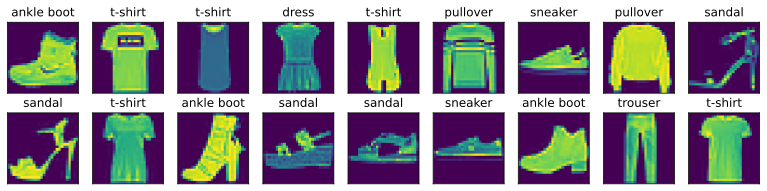

In [56]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [57]:
batch_size = 256

def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

In [58]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [71]:
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

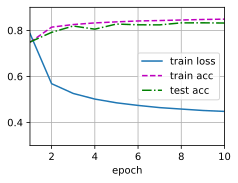

In [77]:
num_inputs = 784  # 28*28的图像，每一个像素点看成一个特征，平铺开就是784个特征输入
num_outputs = 10  # 总共需要分成10个类别，因此bias的数量也是10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)  #找到预测的分类
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

class Accumulator:  #@save
    """在n个变量上累加
    详情参考：https://blog.csdn.net/weixin_44556141/article/details/120116161
    """
    def __init__(self, n):
        self.data = [0.0] * n  # 这个n是使用Accumulator类时需要的一个参数，用来定义储存数据的大小。

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)] # 把self.data和传入的args做元素对应的加法，然后赋值给self.data，从而达到累加的效果

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):  # 判断updater的类型
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss     # 断言如果不通过就抛出异常
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc


lr = 0.1

def updater(batch_size):  # 这里是自己定义了updater，所以在后面training的时候就没有用torch.optim.Optimizer的优化器
    return d2l.sgd([W, b], lr, batch_size)

num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)


softmax的简洁表示

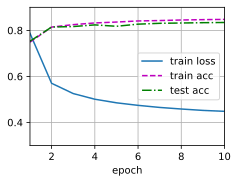

In [6]:
import torch
from torch import nn
from d2l import torch as d2l

# 设定batch_size，导入训练和测试数据集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

# 设定网络结构
net = nn.Sequential(nn.Flatten(), nn.Linear(784,10))  #nn.Flatten()把256*28*28的数据展平成256*784的大小

# 定义初始化网络参数函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

# 定义loss函数
loss = nn.CrossEntropyLoss(reduction='none')

# 定义优化函数
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

# 开始训练模型
num_epochs = 10
net.apply(init_weights)  # 初始化网络参数

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
'''
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型（定义见第3章）

    Defined in :numref:`sec_softmax_scratch`"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc
'''